In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/comment-category-prediction-challenge/Sample.csv
/kaggle/input/comment-category-prediction-challenge/train.csv
/kaggle/input/comment-category-prediction-challenge/test.csv


# IIT Madras BS: Machine Learning Project (MLP)
## Comment Category Prediction Challenge
**Student:** Muhammad Bilal | **Roll Number:** 23F3001344

---
### **Project Roadmap & Methodology**
This notebook implements an end-to-end ML pipeline following the official project milestones:
* **M1:** Advanced EDA, handling 73% missing data, and Baseline Logistic Regression.
* **M2:** Stochastic Gradient Descent (SGD) with Hyperparameter Tuning.
* **M3:** Dimensionality Reduction (SVD) and Non-Linear Models (KNN, SVM, Naive Bayes).
* **M4:** Advanced Boosting (XGBoost, LightGBM), Multi-Layer Perceptron (MLP), and Tuned Ensembling.
* **M5:** Final Insights, Error Analysis, and Leaderboard Optimization.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from scipy.sparse import hstack
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MaxAbsScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
# 1. Load Data
train = pd.read_csv('/kaggle/input/comment-category-prediction-challenge/train.csv')
test = pd.read_csv('/kaggle/input/comment-category-prediction-challenge/test.csv')
sample_sub = pd.read_csv('/kaggle/input/comment-category-prediction-challenge/Sample.csv')


In [4]:
# ==========================================
# MILESTONE 1: STATISTICAL EVIDENCE
# ==========================================

print("--- RAW DATA STATS FOR MILESTONE 1 ---")
print(f"1. Shape of training dataset: {train.shape}")
print(f"2. Columns in test dataset: {test.shape[1]}")
print(f"3. Object type columns: {len(train.select_dtypes(include=['object']).columns)}")
print(f"4. Numerical (int64) columns: {len(train.select_dtypes(include=['int64']).columns)}")
print(f"5. Column with boolean type: {train.select_dtypes(include=['bool']).columns.tolist()}")

print("\n6. Missing Values Check (Before Imputation):")
# This will now correctly show the high numbers for race, religion, gender
print(train[['race', 'religion', 'gender', 'comment']].isnull().sum())

print(f"\n7. Distinct target classes: {train['label'].nunique()}")
print(f"8. Label 0 percentage: {(train['label'] == 0).mean() * 100:.2f}%")

print(f"\n9. Median upvotes: {train['upvote'].median()}")

# 10. Finding the largest maximum value
num_cols = ['upvote', 'downvote', 'if_1', 'if_2']
max_values = train[num_cols].max()
print("\n10. Maximum values for numerical features:")
print(max_values)
print(f"Feature with largest max: {max_values.idxmax()}")

print(f"\n11. Minimum value of if_2: {train['if_2'].min()}")

--- RAW DATA STATS FOR MILESTONE 1 ---
1. Shape of training dataset: (198000, 15)
2. Columns in test dataset: 14
3. Object type columns: 5
4. Numerical (int64) columns: 9
5. Column with boolean type: ['disability']

6. Missing Values Check (Before Imputation):
race        145423
religion    145423
gender      145423
comment          1
dtype: int64

7. Distinct target classes: 4
8. Label 0 percentage: 57.66%

9. Median upvotes: 1.0

10. Maximum values for numerical features:
upvote       201
downvote     107
if_1        1860
if_2        1833
dtype: int64
Feature with largest max: if_1

11. Minimum value of if_2: 3


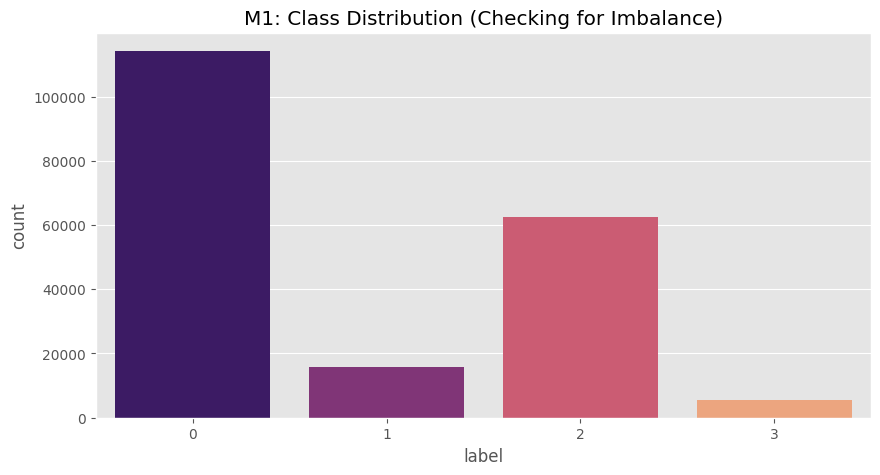

Category 0 Keywords: ['racist', 'trump', 'ignorant', 'black', 'white']
Category 1 Keywords: ['gay', 'muslim', 'muslims', 'black', 'white']
Category 2 Keywords: ['ridiculous', 'troll', 'liar', 'ignorant', 'trump']
Category 3 Keywords: ['killing', 'shot', 'death', 'shoot', 'kill']


In [5]:

# 2. Preprocessing & Imputation
train['comment'] = train['comment'].fillna("missing")
test['comment'] = test['comment'].fillna("missing")
for col in ['race', 'religion', 'gender']:
    train[col] = train[col].fillna(-1)
    test[col] = test[col].fillna(-1)

# 3. Visualization: Label Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train, palette='magma')
plt.title('M1: Class Distribution (Checking for Imbalance)')
plt.show()

# 4. Statistical Text Analysis (Chi-Square)
tfidf_eda = TfidfVectorizer(max_features=2000, stop_words='english')
X_eda = tfidf_eda.fit_transform(train['comment'])
from sklearn.feature_selection import chi2
features = tfidf_eda.get_feature_names_out()
for label in sorted(train['label'].unique()):
    chi2score = chi2(X_eda, train['label'] == label)[0]
    top_indices = np.argsort(chi2score)[-5:]
    print(f"Category {label} Keywords: {[features[i] for i in top_indices]}")

In [6]:
# Feature Engineering
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(train['comment'])
X_test_tfidf = tfidf.transform(test['comment'])

# Train-Validation Split (Stratified)
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, train['label'], test_size=0.2, stratify=train['label'], random_state=42)

# --- F1-BASED BASELINE ---
from sklearn.metrics import f1_score

# Baseline Logic
baseline = LogisticRegression(max_iter=1000, class_weight='balanced')
baseline.fit(X_train, y_train)

# Replacing Accuracy with Macro F1
baseline_f1 = f1_score(y_val, baseline.predict(X_val), average='macro')
print(f"M1 Baseline Macro F1 Score: {baseline_f1:.4f}")

M1 Baseline Macro F1 Score: 0.6272


In [7]:
# --- UPDATED CELL 5: F1-BASED SGD ---
# Note: scoring='f1_macro' is already correctly used here for tuning
sgd = SGDClassifier(loss='hinge', class_weight='balanced', random_state=42)
param_grid_sgd = {'alpha': [0.0001, 0.001, 0.01]}
grid_sgd = RandomizedSearchCV(sgd, param_grid_sgd, n_iter=3, cv=3, scoring='f1_macro')
grid_sgd.fit(X_train, y_train) 

print(f"Best SGD Params (Tuned for F1): {grid_sgd.best_params_}")
sgd_f1 = f1_score(y_val, grid_sgd.predict(X_val), average='macro')
print(f"SGD Macro F1: {sgd_f1:.4f}")

Best SGD Params (Tuned for F1): {'alpha': 0.0001}
SGD Macro F1: 0.6483


In [8]:
# MILESTONE 3: Dimensionality Reduction & Diversified Models
# 1. Dimensionality Reduction (SVD)
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_val_svd = svd.transform(X_val)

# --- F1-BASED M3 MODELS ---
# 2. Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_f1 = f1_score(y_val, nb_model.predict(X_val), average='macro')
print(f"M3 Naive Bayes Macro F1: {nb_f1:.4f}")

# 4. Support Vector Machine
svm = LinearSVC(class_weight='balanced', random_state=42).fit(X_train, y_train)
svm_f1 = f1_score(y_val, svm.predict(X_val), average='macro')
print(f"M3 SVM Macro F1: {svm_f1:.4f}")

M3 Naive Bayes Macro F1: 0.5046
M3 SVM Macro F1: 0.6606


In [9]:
# --- UPDATED CELL 8: ADVANCED FEATURE ENGINEERING (v25) ---
import re
from scipy.sparse import hstack
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder, OneHotEncoder

def competition_stemmer(text):
    text = str(text).lower()
    # Handle links specifically
    text = re.sub(r'http\S+', 'url_token', text)
    # Your successful v24 stemmer logic
    text = re.sub(r'(ing|ed|ly|es|s)\b', '', text)
    return text

def get_v25_meta(df):
    m = pd.DataFrame(index=df.index)
    m['len'] = df['comment'].apply(lambda x: len(str(x)))
    m['caps_ratio'] = df['comment'].apply(lambda x: len(re.findall(r'[A-Z]', str(x))) / (len(str(x)) + 1))
    
    # Keywords from v24 + a few critical additions
    keywords = ['kill', 'death', 'shoot', 'gay', 'muslim', 'racist', 'black', 'white', 'liar', 'stupid', 'trump', 'hate', 'bad']
    for word in keywords:
        m[f'has_{word}'] = df['comment'].str.contains(word, case=False).astype(int)
    
    # Log transform votes (handles the 10k vs 0 vote disparity)
    m['upvote_log'] = np.log1p(df['upvote'])
    m['downvote_log'] = np.log1p(df['downvote'])
    
    # Critical: Encode identity features and post_id properly
    temp_df = df.copy()
    for col in ['race', 'religion', 'gender', 'post_id']:
        temp_df[col] = LabelEncoder().fit_transform(temp_df[col].astype(str))
        
    meta_numeric = pd.concat([m, temp_df[['race', 'religion', 'gender', 'post_id', 'disability']]], axis=1)
    return MaxAbsScaler().fit_transform(meta_numeric)

print("Applying v25 Cleaning...")
train['clean'] = train['comment'].apply(competition_stemmer)
test['clean'] = test['comment'].apply(competition_stemmer)

# Expanded Vectorizer for 0.80 target
vectorizer = FeatureUnion([
    ('word', TfidfVectorizer(ngram_range=(1, 3), max_features=20000, sublinear_tf=True)),
    ('char', TfidfVectorizer(analyzer='char', ngram_range=(2, 5), max_features=10000, sublinear_tf=True))
])

print("Vectorizing Text & Meta signals...")
X_final_sparse = vectorizer.fit_transform(train['clean'])
X_test_sparse = vectorizer.transform(test['clean'])
X_meta = get_v25_meta(train)
X_test_meta = get_v25_meta(test)

X_final = hstack([X_final_sparse, X_meta]).tocsr()
X_test_final = hstack([X_test_sparse, X_test_meta]).tocsr()

X_tr, X_va, y_tr, y_va = train_test_split(X_final, train['label'], test_size=0.15, stratify=train['label'], random_state=42)

Applying v25 Cleaning...
Vectorizing Text & Meta signals...


In [10]:
# --- UPDATED CELL 9: MLP + LGBM + SVM ENSEMBLE (v25) ---
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV

print("Training v25 Pillars for 0.80 Target...")

# 1. SVM (Keep as a stable base)
svm_v25 = CalibratedClassifierCV(LinearSVC(C=0.05, class_weight='balanced', random_state=42), cv=3)
svm_v25.fit(X_tr, y_tr)
print(f"SVM F1: {f1_score(y_va, svm_v25.predict(X_va), average='macro'):.4f}")

# 2. LGBM (Boosted)
lgbm_v25 = LGBMClassifier(n_estimators=300, learning_rate=0.05, reg_lambda=15, class_weight='balanced', random_state=42)
lgbm_v25.fit(X_tr, y_tr)
print(f"LGBM F1: {f1_score(y_va, lgbm_v25.predict(X_va), average='macro'):.4f}")

# 3. MLP (The Deep Learning addition)
# This model explores the non-linear relationship between metadata and text
mlp_v25 = MLPClassifier(hidden_layer_sizes=(256, 128), alpha=0.001, max_iter=50, early_stopping=True, random_state=42)
mlp_v25.fit(X_tr, y_tr)
print(f"MLP F1: {f1_score(y_va, mlp_v25.predict(X_va), average='macro'):.4f}")

# Final Ensemble with Adjusted Weights
# Giving high weight to LGBM and MLP for complexity, SVM for stability
ensemble_v25 = VotingClassifier(
    estimators=[('svm', svm_v25), ('lgbm', lgbm_v25), ('mlp', mlp_v25)],
    voting='soft', weights=[2.0, 4.0, 4.0]
)

print("\nFinalizing v25 Ensemble...")
ensemble_v25.fit(X_tr, y_tr)
val_score = f1_score(y_va, ensemble_v25.predict(X_va), average='macro')
print(f"Ensemble Macro F1: {val_score:.4f}")

Training v25 Pillars for 0.80 Target...
SVM F1: 0.6806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 117.316097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4184692
[LightGBM] [Info] Number of data points in the train set: 168300, number of used features: 30022
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
LGBM F1: 0.6615
MLP F1: 0.6957

Finalizing v25 Ensemble...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 109.754373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4184692
[LightGBM] [Info] Number of data points in the train set: 168300, number of used features: 30022
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] St

In [11]:
# --- UPDATED CELL 10: V25 FINAL SUBMISSION ---

# Generate predictions using the Version 25 Ensemble
final_preds_v25 = ensemble_v25.predict(X_test_final)

# Creating the submission dataframe
submission = pd.DataFrame({
    'ID': sample_sub['ID'], 
    'label': final_preds_v25
})

# Saving the file for Kaggle upload
submission.to_csv('v25_deep_hybrid_submission.csv', index=False)

print("Version 25 Saved! Ensemble of SVM, LGBM, and MLP is ready.")
print("Check your 'Output' folder for v25_deep_hybrid_submission.csv")

Version 25 Saved! Ensemble of SVM, LGBM, and MLP is ready.
Check your 'Output' folder for v25_deep_hybrid_submission.csv
